In [1]:
## so its our favourite application area in DL 
## HIp hip hooray make way for CV

In [2]:
## typical workflow for CV
## Import cv pytorch libs
## load data[ibuilt/custom]
## preprocess 
## model building
## making predictions[w/ baseline model]
## setup generic reusable code for future work
## improve model
## Add Non Linearity+CNN+etc..
## Compare which model performed well
## Evaluate the  results with the help of Confusion matrix
## saving and loading the best model
## Depending on the work some of the steps mentioned above 
## can be omitted without the loss of generality



In [3]:
## CV pytorch Libs includes
## torchvision. -> torchvision.models
## for datasets[inbuilt] purpose
## torch.util.data.datasets or torchvision.datasets
## Transformation -> torchvision.transforms
## Ok we'll get to know it better in due course of time
## So lets get started


In [4]:
## importing libs
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
## checking

In [5]:
torchvision.__version__, torch.__version__

('0.15.1', '2.0.0')

In [6]:
## Lets start with inbuilt dataset such as FshionMNIST
train_data = datasets.FashionMNIST(
root = "data",## path to downloaded data
train=True, ## getting train data
download = True, ## download if it doesn't exist
transform=ToTensor(),## format of Image PIL hence convert to tensor format
target_transform = None ## we'll see this one later..)
)
    

    

100%|██████████| 26421880/26421880 [00:02<00:00, 12320009.94it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210091.39it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3940431.81it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3549026.46it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [7]:
## seting up tets data
test_data = datasets.FashionMNIST(
root="data",
train=False,
download=True,
transform=ToTensor()
)

In [8]:
## lets check the downloaded data
image , label = train_data[0]
image.shape,  len(image), label

(torch.Size([1, 28, 28]), 1, 9)

In [9]:
## so the dataset got a total of 9 labels
## hence its going to be a multi class classification problem
## [1,28,28] -> [nos channel, height, width] -> monochrome[greyscale] images of dimension 28x28
## other format includes ->> [N,C,H,W] -> [batchsize/nos of images, nos of channel, height, width]
## the best practice is [NHWC]

## okay lets check the number of images
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)



(60000, 60000, 10000, 10000)

In [10]:
## okay so what are those classes
class_type = train_data.classes
class_type

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Image shape _torch.Size([1, 28, 28])


Text(0.5, 1.0, '9')

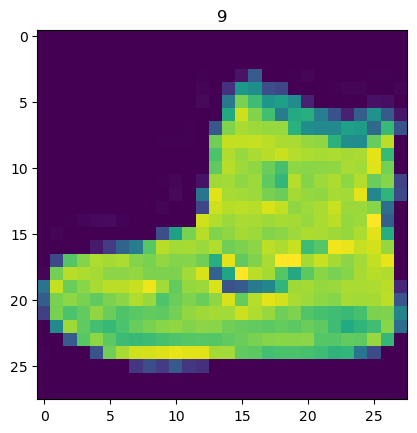

In [11]:
## so how does those data appears to be
image , label = train_data[0]
print(f"Image shape _{image.shape}")
plt.imshow(image.squeeze())
plt.title(label)

Text(0.5, 1.0, 'Ankle boot')

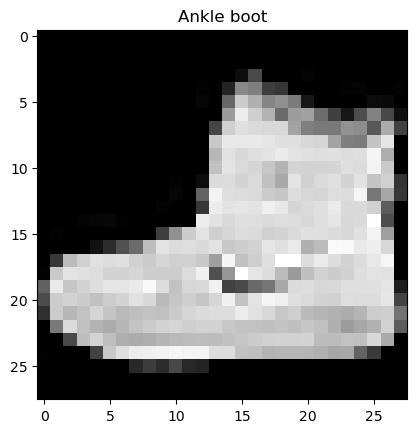

In [12]:
## Greyscale???
plt.imshow(image.squeeze(), cmap = "gray")
plt.title(class_type[label])

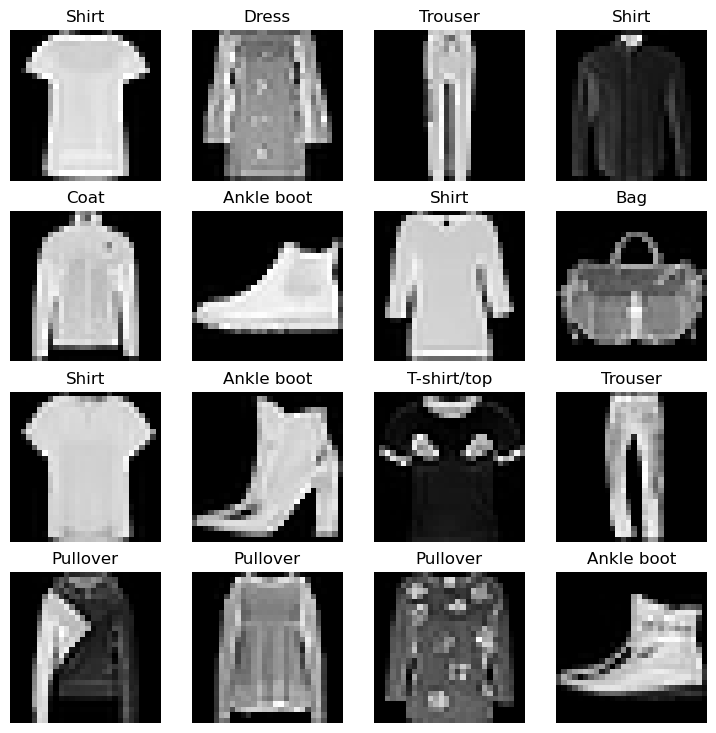

In [13]:
## ah thats great .. lets look into more images...
torch.manual_seed(482)
fig = plt.figure(figsize=(9,9))
rows , cols = 4,4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data),size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_type[label])
    plt.axis(False)

In [14]:
## for further processing lets prepare the DataLoader
## what purpose does dataloader serves??
## process large dataset -> smaller chunks of python iterables [batches]
## load data into model for training and inference
## why batches ?? -> computationally efficient
## size of those mini batches -> 32 or relatively in power of 2


from torch.utils.data import DataLoader
batsiz = 32 ## also a hyperparameter

## turm dataset into iterables
train_dataloader = DataLoader(train_data, batch_size= batsiz,shuffle=True)
## shuffle allows data to be shuffled in every epoch
test_dataloader = DataLoader(test_data, batch_size=batsiz, shuffle=False)
## you may/maynot shuffle the testing data

print(f"Dataloader: {train_dataloader, test_dataloader}")
print(f"length of the train dataloader__{len(train_dataloader)}")
print(f"length of the test dataloader__{len(test_dataloader)}")





Dataloader: (<torch.utils.data.dataloader.DataLoader object at 0x78d0813b3bb0>, <torch.utils.data.dataloader.DataLoader object at 0x78d08134d480>)
length of the train dataloader__1875
length of the test dataloader__313


In [15]:
## shall we take a peek into the dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label : 8, label size: torch.Size([])


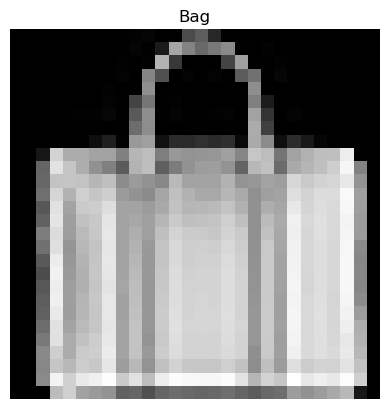

In [16]:
## note the format of the presentation of the data
## lets check a sample
torch.manual_seed(433)
random_idx = torch.randint(0, len(train_features_batch),size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_type[label])
plt.axis("off")
print(f"Image size: {img.shape}")
print(f"Label : {label}, label size: {label.shape}")


In [17]:
## Baseline model 0
## simplest model and consist of two linear layers
## but since we're dealing with the image data, we need a way
## to flatten them in order to feed then to linear layers
## so we'll use nn.Flatten() -> compresses the dimension of tensor into a single vector

## To create a flattening layer
flatten_model = nn.Flatten() 
## a single sample is taken
x = train_features_batch[0]

## Flatten the sample
output = flatten_model(x)

## lets see the output of the flatten layer
print(x.shape, output.shape, len(x))



torch.Size([1, 28, 28]) torch.Size([1, 784]) 1


In [18]:
## lets define the blueprint of our baseline model
class FashionMnistModel_0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features= hidden_units, out_features = output_shape)
        )
    def forward(self, x):
        return self.layer_stack(x)

    



In [19]:
## its time to instantiate a model
torch.manual_seed(52)
model_0 = FashionMnistModel_0(input_shape=784, hidden_units=10,output_shape=len(class_type))
model_0.to("cpu") ## we'll load it in GPU later

FashionMnistModel_0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [20]:
## get some help with the helper function
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [21]:
## importing accuracy metric
from helper_functions import accuracy_fn
## seting up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(), lr=0.1)


In [22]:
## the reason why we let the model persist on CPU because
## we want to check the amount of time it requires
## to run on both devices. That way we'll make inference
## as to whether we really train our model in GPU
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [23]:
## this time the training will be different
## steps
## loop through the epochs
## loop through the training batches, perform testing steps, calc loss
## same as above but for test batches
## print out the stats
## and jot down the time
## so here we go



## for progress bar
from tqdm.auto import tqdm
## setting seed and timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

## set the number of epochs
epochs = 3

## creating training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch:  {epoch}\n-----")
    ##training
    train_loss = 0
    ## add a loop to loop through the training batch
    for batch, (X,y) in enumerate(train_dataloader):
        model_0.train()
        ## forward pass 
        y_pred = model_0(X)
        ## calc loss(per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        ##setting optimizer to 0
        optimizer.zero_grad()
        ## backprop
        loss.backward()
        ## update the optimizer
        optimizer.step()
        
        ## printing out stats
        if batch%400 ==0:
            print(f"Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples")
    
    train_loss /= len(train_dataloader)
    ## testing time
    ## setup the vars
    test_loss, test_acc = 0,0
    model_0.eval()
    with torch.inference_mode():
        for X,y in test_dataloader:
            ## forward pass
            test_pred = model_0(X)
            ## calc loss
            test_loss += loss_fn(test_pred, y)
            ## accuracy
            test_acc += accuracy_fn(y_true = y, y_pred = test_pred.argmax(dim=1))
        
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    print(f"Train_loss _{train_loss}|| test_loss_{test_loss}|| test_accuracy_{test_acc}")

# Calculate training time      
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

        


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch:  0
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train_loss _0.5889773368835449|| test_loss_0.5039510726928711|| test_accuracy_82.34824281150159
Epoch:  1
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train_loss _0.47580134868621826|| test_loss_0.4836200177669525|| test_accuracy_82.84744408945687
Epoch:  2
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train_loss _0.45461198687553406|| test_loss_0.47721362113952637|| test_accuracy_83.50638977635782
Train time on cpu: 26.307 seconds


In [24]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'FashionMnistModel_0',
 'model_loss': 0.47721362113952637,
 'model_acc': 83.50638977635782}

In [25]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [26]:
## lets try something really different like adding non-linearity
class FashionMnistModel_1(nn.Module):
    def __init__(self, inn: int, hid_uni: int, outs :int ):
        super().__init__()
        self.layerstack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=inn, out_features=hid_uni),
        nn.ReLU(),
        nn.Linear(in_features = hid_uni, out_features=outs),
        nn.ReLU())
    def forward(self, x: torch.Tensor):
        return self.layerstack(x)

In [27]:
## standard ML practice -> change a thing repeat experiments several times and note down readings
torch.manual_seed(43)
model_1 = FashionMnistModel_1(inn=784, hid_uni=10,outs=len(class_type))
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [28]:
## setting up loss optimizer and evaluation metrics
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr =0.1)

In [29]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [30]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_1, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.86674 | Train accuracy: 68.40%
Test loss: 0.52723 | Test accuracy: 81.95%

Epoch: 1
---------
Train loss: 0.48883 | Train accuracy: 82.62%
Test loss: 0.48935 | Test accuracy: 82.53%

Epoch: 2
---------
Train loss: 0.45399 | Train accuracy: 83.65%
Test loss: 0.47151 | Test accuracy: 83.08%

Train time on cuda: 30.580 seconds
